# Example - Influence calculation

In this code, we exemplify how to use our pipeline to compute Influence.

Influence is a novel metric for transformer explainability that leverages attention scores and embedding vectors to assess the importance of a specific subsequence of tokens throughout the context length.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
while "examples" in os.getcwd():
    os.chdir("..")

# from pipeline import 
from transformers import pipeline
from transformers.pipelines import PIPELINE_REGISTRY
from transformers import AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig

from pay_attention_pipeline import PayAttentionPipeline
import torch

import pandas as pd

import matplotlib.pyplot as plt

## Loading generative model

We recommend using only Mistral or Llama models for now, due to specific implementation details in HuggingFace.

In [3]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)


tokenizer = AutoTokenizer.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    cache_dir = "/Data"    
)

base_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    quantization_config = quantization_config,
    device_map="auto",
    attn_implementation="eager",
    cache_dir = "/Data" 
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [65]:
def rolling_mean(data, window_size):
    # Ensure the data is a 1D tensor
    data = torch.tensor(data, dtype=torch.float32)
    
    # Reshape data to (batch_size=1, num_channels=1, sequence_length)
    data = data.view(1, 1, -1)
    
    # Create a kernel that computes the mean
    kernel = torch.ones(window_size) / window_size
    kernel = kernel.view(1, 1, -1)  # Reshape to (out_channels=1, in_channels=1, kernel_size)

    # Apply 1D convolution to compute the rolling mean
    rolling_mean = F.conv1d(data, kernel, padding=0)
    
    # Remove extra dimensions and return result
    return rolling_mean.view(-1)

## Loading pipeline

In [4]:
pipe= pipeline(
    "pay-attention", 
    model = base_model,
    tokenizer = tokenizer, 
    model_kwargs=dict(cache_dir = "/Data"),
)

## Compting influence

Add the tag ```<?-> <-?>``` between the text that you want the influence to be computed to.

In this notebook, we compute the influence of the instruction ```Rewrite in French``` over context length

In [5]:
prompt = '''
The Eiffel Tower, an iconic symbol of Paris and France, was completed in 1889 as the centerpiece of the Exposition Universelle, a world’s fair celebrating the centennial of the French Revolution. Standing at 330 meters (1,083 feet) today after several modifications, this iron lattice tower was initially met with controversy from many prominent Parisians who found its design unattractive. However, it quickly became a beloved landmark and an engineering marvel of its time.

Designed by the engineer Gustave Eiffel, the tower was initially intended to be a temporary structure, set to be dismantled after 20 years. However, its usefulness as a radiotelegraphy tower ensured its survival. Today, it is one of the most visited paid monuments in the world, attracting millions of tourists each year who come to admire the breathtaking views of Paris from its observation decks.

The Eiffel Tower is not just a feat of engineering but also a symbol of innovation, representing a turning point in the use of materials and construction techniques in architecture. Its elegant iron framework, which was revolutionary in its time, is now celebrated as an enduring symbol of the art and science of building.
'''

In [6]:
len(tokenizer(prompt)['input_ids'])

274

In [81]:
out = pipe("<?-> Rewrite in French <-?>" + prompt, max_new_tokens = 100, )
out_delta = pipe("<?-> Rewrite in French <-?>" + prompt, max_new_tokens = 100, delta_influence=1)
out_rollout =pipe("<?-> Rewrite in French <-?>" + prompt, max_new_tokens = 100, metric = 'attention_rollout')
out_caps = pipe("<?-> REWRITE IN FRENCH <-?>" + prompt, max_new_tokens = 100, )


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Computing influence on 'Rewrite in French'. Delta = 0


/users/eleves-a/2022/pedro.silva/Desktop/pay_attention_pipeline/pay_attention_pipeline/src/metrics.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dtype = embedding.dtype
100%|██████████| 32/32 [00:00<00:00, 979.41it/s]


Passing tensors to CPU...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Computing influence on 'Rewrite in French'. Delta = 1


100%|██████████| 32/32 [00:00<00:00, 913.39it/s]


Passing tensors to CPU...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Computing influence on 'Rewrite in French'. Delta = 0


100%|██████████| 32/32 [00:00<00:00, 1072.08it/s]


Passing tensors to CPU...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Computing influence on 'REWRITE IN FRENCH'. Delta = 0


100%|██████████| 32/32 [00:00<00:00, 983.11it/s]


Passing tensors to CPU...


## Output format

The output is a list of dicts, containing both the generated text and the influence, another dict that contains the influence on each layer (from ```0``` to ```NUM_LAYERS - 1$```)

In [89]:
influence = out[0]['influence']
influence_delta = out_delta[0]['influence']
rollout = out_rollout[0]['influence']
influence_caps = out_caps[0]['influence']

In [90]:
import hvplot.pandas  # noqa

pd.options.plotting.backend = 'holoviews'

In [92]:
layers_to_plot = [0, 15, 31]
layers_to_axs_idx = {v: i for i, v in enumerate(layers_to_plot)}
n_plots = len(layers_to_plot)
# fig, axes = plt.subplots(1, n_plots, figsize=(n_plots * 5, 4))
layer_idx = 15

# for layer_idx in layers_to_plot:

v1 = torch.log(influence[layer_idx])
influence_vect = pd.DataFrame(v1).rename(columns = {0:"Raw prompt"})
influence_vect['token_raw']= tokenizer.convert_ids_to_tokens(out[0]['tokens'][0])

v2 = torch.log(influence_delta[layer_idx])
influence_vect_delta = pd.DataFrame(v2).rename(columns = {0:r"Delta = 1"})

v3 = torch.log(rollout[layer_idx])
rollout_vect = pd.DataFrame(v3).rename(columns = {0:r"Attention rollout"})


v4= torch.log(influence_caps[layer_idx])
influence_vect_caps = pd.DataFrame(v4).rename(columns = {0:"Uppercase"})
influence_vect_caps['token_uppercase'] = tokenizer.convert_ids_to_tokens(out_caps[0]['tokens'][0])

influence_df = pd.concat([
    influence_vect, 
    influence_vect_caps, 
    influence_vect_delta,
    rollout_vect
    ], 
    axis = 1
)
influence_df['index'] = range(len(influence_df)) 

plot = influence_df.hvplot.line(
    x = 'index', 
    y = ['Raw prompt', 'Uppercase', "Delta = 1", "Attention rollout"], 
    hover_cols = ['token_raw', 'token_uppercase'], 
    xlabel = 'Context length',
    ylabel = 'log influence', 
    title = f"Influence - Layer {layer_idx}"
)

plot

:NdOverlay   [Variable]
   :Curve   [index]   (value,token_raw,token_uppercase)

/tmp/ipykernel_302692/3785904737.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)


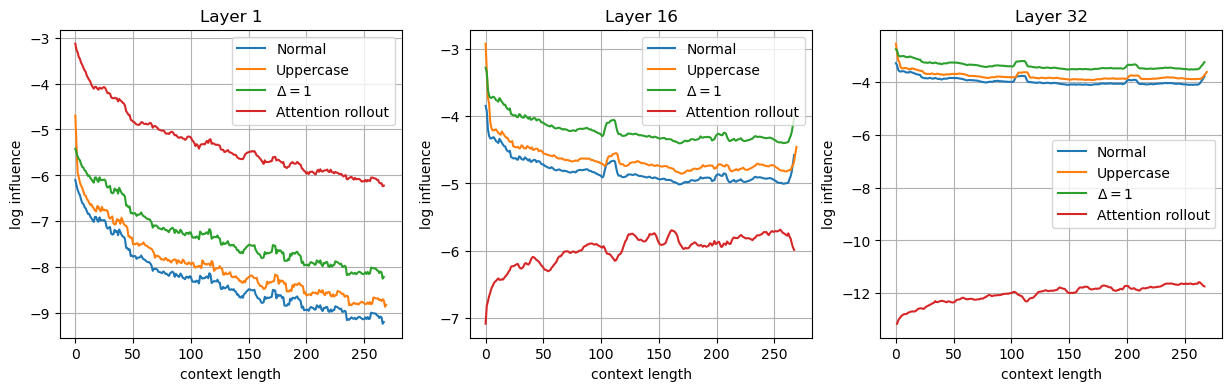

In [93]:
layers_to_plot = [0, 15, 31]
layers_to_axs_idx = {v: i for i, v in enumerate(layers_to_plot)}
n_plots = len(layers_to_plot)
fig, axes = plt.subplots(1, n_plots, figsize=(n_plots * 5, 4))

for layer_idx in layers_to_plot:
    plot_idx = layers_to_axs_idx[layer_idx]
    axes[plot_idx].plot(
        rolling_mean(torch.log(influence[layer_idx]), 10)[10:],
        label = "Normal"
    )
    axes[plot_idx].plot(
        rolling_mean(torch.log(influence_caps[layer_idx]), 10)[10:],
        label = "Uppercase"
    )

    axes[plot_idx].plot(
        rolling_mean(torch.log(influence_delta[layer_idx]), 10)[10:],
        label = r"$\Delta = 1$"
    )

    axes[plot_idx].plot(
        rolling_mean(torch.log(rollout[layer_idx]), 10)[10:],
        label = r"Attention rollout"
    )


    axes[plot_idx].set_title(f"Layer {layer_idx+1}")
    axes[plot_idx].grid()
    axes[plot_idx].set_xlabel("context length")
    axes[plot_idx].set_ylabel("log influence")
    axes[plot_idx].legend()

plt.savefig("img/example_influence.png")